# Trait Weight Based Optimization

In [1]:
#imports required
import numpy as np
import numpy.random as rnd
import scipy
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from numpy import linalg as LA
import cvxpy as cp
import exp_setup
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from trait_weight_optimization.exp_setup import *

%load_ext autoreload
%autoreload 2

In [2]:
#installations

### Setup

We will modelling the robot team allocation to solve few independent challenges.

The species will be the 20 types of robots(divided into 4 groups).For each demonstration, each type of robot from the group will be randomly assigned to the expert.

There are 9 traits for each robot specie which are generic and mostly applicable to all of them. 

There are three task which are required to be completed with the allocation. 

In [3]:
# experiment settings
num_species = 4 #drone,rover,mini-rover,mini-drone
num_tasks = 3  #pick,search for target,move object
num_traits = 9 #speed,footprint,payload,reach,weight,sensing frequency,sensing range,color,battery capacity
traits = ["speed","footprint","payload","reach","weight","sensing frequency","sensing range","color","battery"]
num_demo = 1500

## Random Q vs Deterministic Q

### RANDOM Q

In [4]:
Q = []
for i in range(num_demo):
    Q.append(get_random_q())
Q = np.array(Q)
Q.shape

(1500, 4, 9)

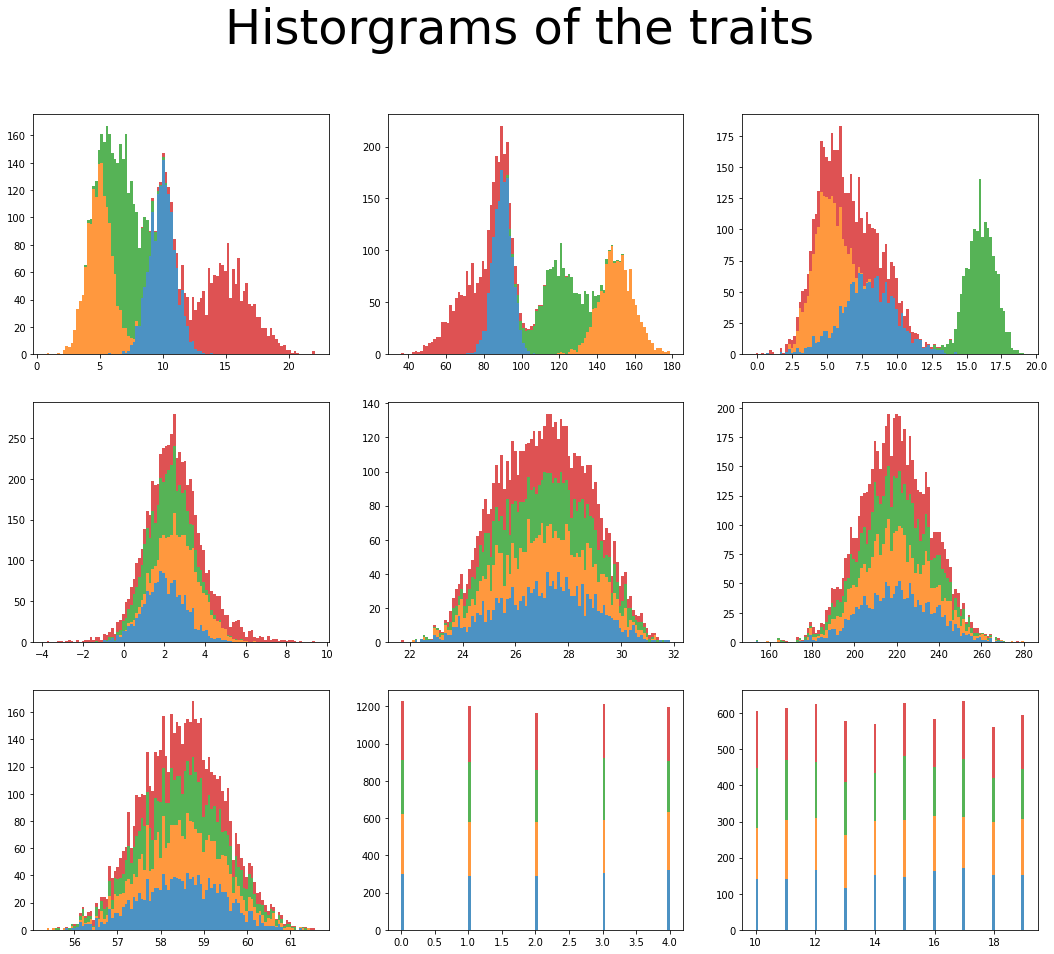

In [5]:
plt.rcParams["figure.figsize"] = (18,15)

create_trait_histogram(plt,Q)
# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.hist(Q[:,:,i], bins=100, density=False,histtype='barstacked', alpha=0.8)

# figure.suptitle("Historgrams of the traits",  fontsize=48)

In [6]:
# #Visualizations
# plt.rcParams["figure.figsize"] = (18,15)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.plot(range(num_demo), Q[:,:,i],alpha=0.6)
#     ax.set_title(traits[i])

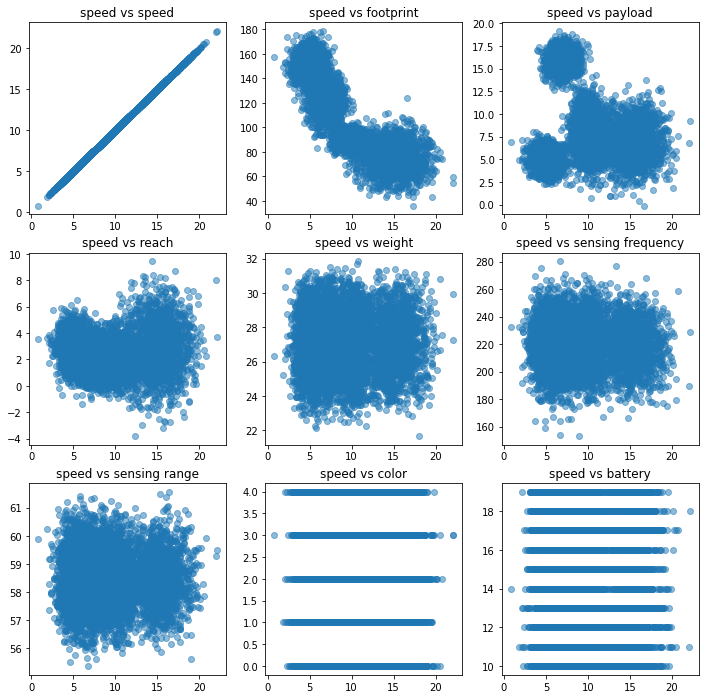

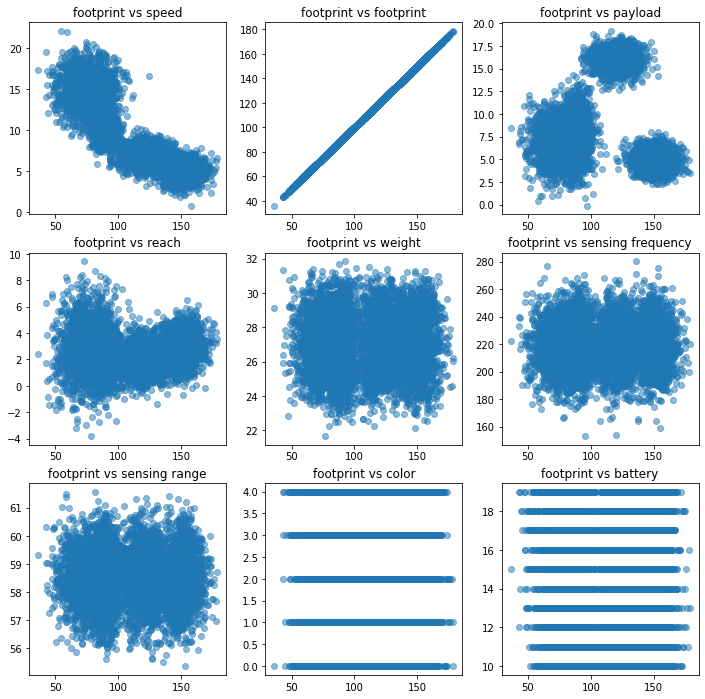

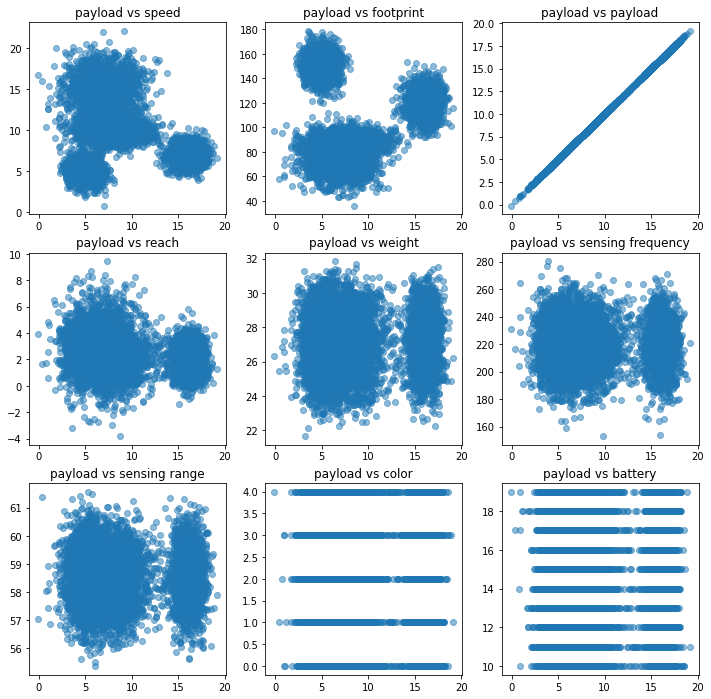

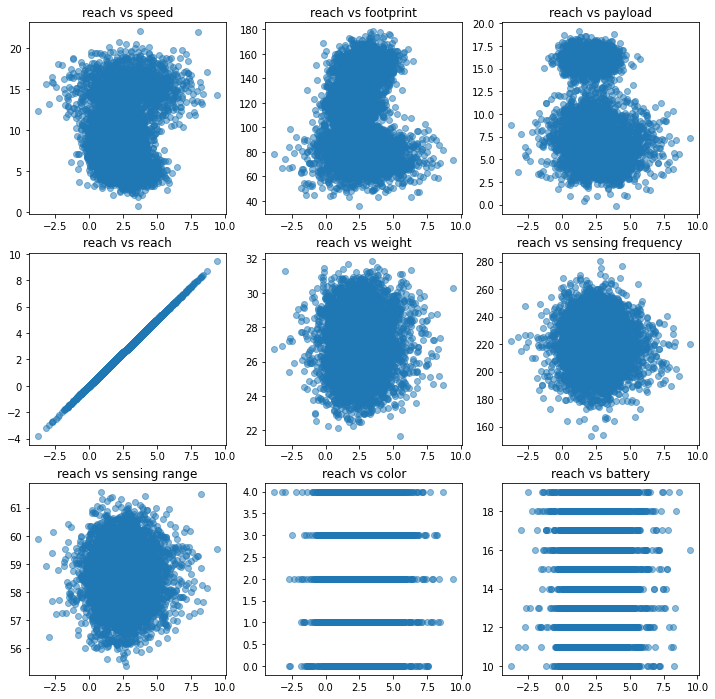

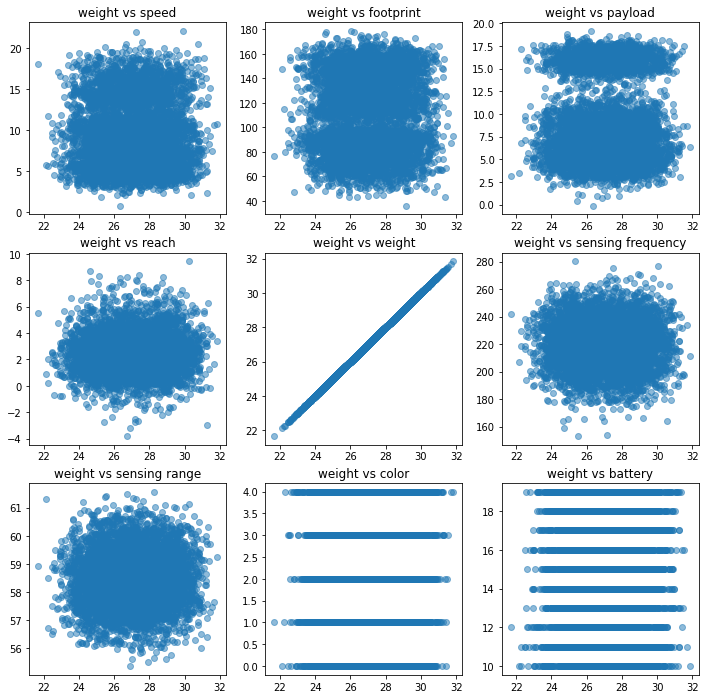

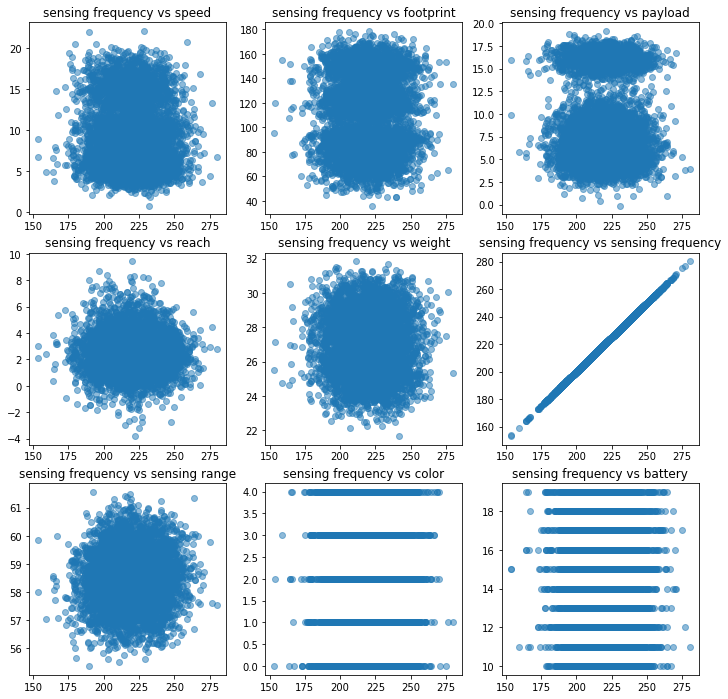

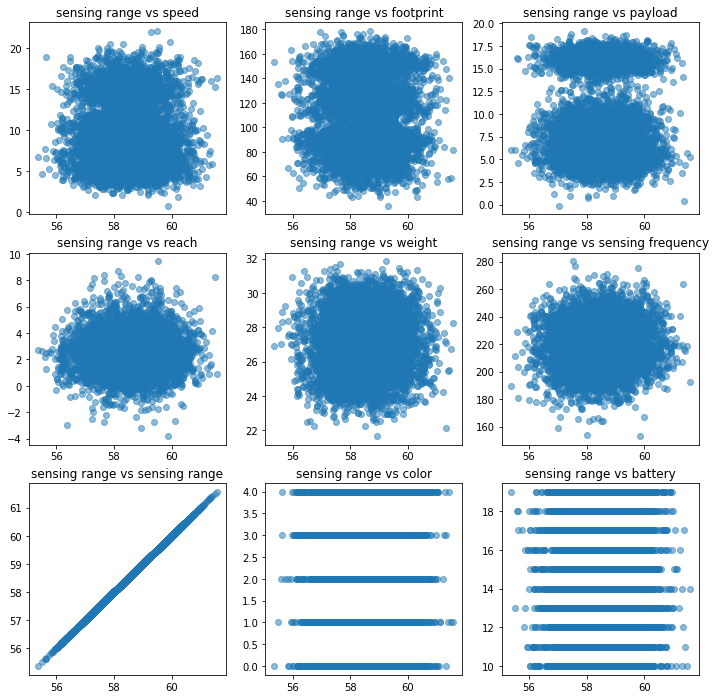

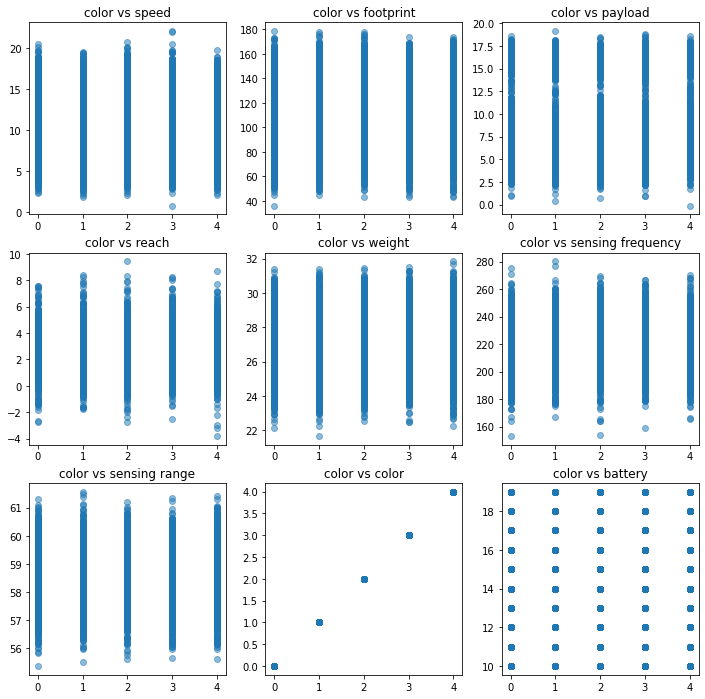

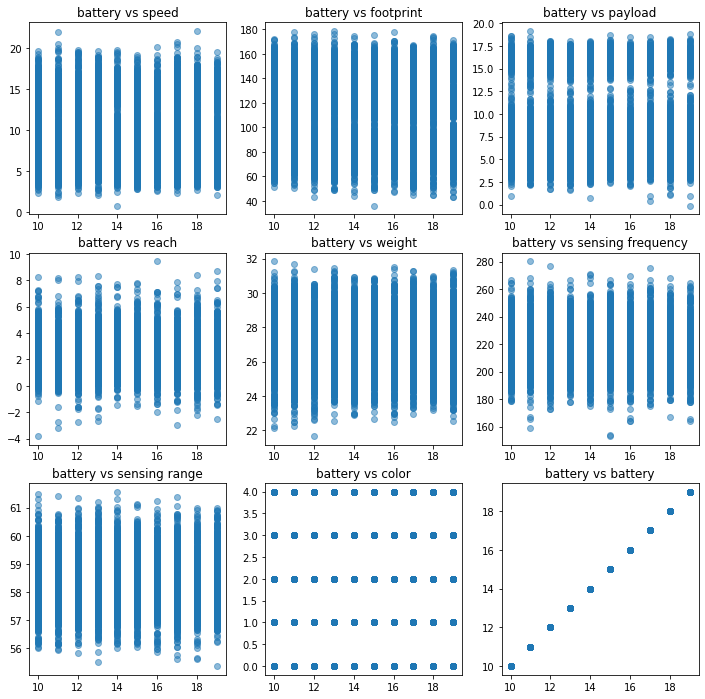

In [7]:
#Visualization Trait space

#Traits with respect to other traits can be mapped to visualize the traits spaces

#Visualizations
plt.rcParams["figure.figsize"] = (12,12)

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(Q[:,:,t], Q[:,:,i],alpha=0.5)
        ax.set_title(traits[t] + " vs "+ traits[i] )

(DETERMINISTIC Q)
FAILED IDEA

In [8]:
# Q_det = []
# for i in range(num_demo):
#     Q_det.append(get_deterministic_q())
# Q_det = np.array(Q_det)
# Q_det.shape

In [9]:
# plt.rcParams["figure.figsize"] = (18,15)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.plot(range(num_demo), Q_det[:,:,i],alpha=0.6)
#     ax.set_title(traits[i])

In [10]:
# plt.rcParams["figure.figsize"] = (12,12)

# #self maps
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.scatter(Q_det[:,:,i], Q_det[:,:,i],alpha=0.2)
#     ax.set_title(traits[i] + " vs "+ traits[i] )

# #one trait to another
# for t in range(num_traits):
#     figure, axs = plt.subplots(3,3)
#     for i, ax in enumerate(axs.flat):
#         ax.scatter(Q_det[:,:,t], Q_det[:,:,i],alpha=0.5)
#         ax.set_title(traits[t] + " vs "+ traits[i] )

## Y optimal formualtion

In [11]:
# n_agents_target = np.ones((num_tasks,num_species))*10
# n_agents_target
n_agents_target = np.ones(num_species)*10

In [12]:
#       #speed , footprint , payload , reach , weight , sensing frequency , sensing range,color,battery capacity
# y1 = [167.67539631 , 0 , 163.54336383 , 44.77054672 , 492.53035196 , 4000.24323205 , 1066.20140352 , 0 , 0]#pick
# y2 = [167.26818453 , 1969.70284216 , 0 , 0 , 488.97568317 , 3965.75731709 , 1059.38683684 , 0 , 262.56000000]#search for target
# y3 = [166.81653853 , 1969.43635325 , 161.43957528 , 0 , 488.32231989 , 0 , 1057.86312284 , 0 , 261.07266667]#move object
# y_star = np.array([y1 , y2 , y3]).astype(np.float)
# y_star


# y1 = [163.70974517, 0,  159.18052969,   42.25540358 , 474.86603947,  3915.18485378 ,1044.94916321 ,  0 ,  0]#pick
# y2 = [163.97756868, 1949.61484453 ,0, 0 , 480.46007361,3935.71503043 ,1047.99365735,   0.      ,    253.5       ]#search for target
# y3 = [ 164.43033649, 1957.56082303  ,161.87735218,   0,  486.34644624,0 ,1056.94635674  , 0,         257.5       ]#move object
# y_star = np.array([y1 , y2 , y3]).astype(np.float)

y_star = np.array([[ 122.53839519, 0.,  119.39044525,   32.15983648,
         360.87624558, 2920.25543052,  768.93055775,   0.        ,
         0.        ],
       [ 120.64147124, 1433.4094241 ,  0.,   0.,
         358.13547136, 2906.93229221,  766.11629311,   0.        ,
         190.        ],
       [ 122.31492305, 1441.74082593,  119.06910271,   0.,
         358.78852644, 0. ,  769.11520065,   0.        ,
         193.        ]])

In [13]:
def get_X():
    X_test = np.zeros((num_tasks, num_species))
    task_restrict = range(num_tasks)
    for s in range(num_species):
        R = np.random.choice(task_restrict, size=n_agents_target[s].astype(int))
        for m in task_restrict:
            X_test[m, s] = np.sum(R == m)
        X_test = X_test.round()
    X_test = X_test.astype(np.int32)
    return X_test

In [14]:
X_test = []
for i in range(num_demo):
    x_i = get_X()
    X_test.append(x_i)
X_test = np.array(X_test)
Y_test = X_test@Q
print(Y_test.shape)
print(np.median(Y_test,axis=0))
print(np.mean(Y_test,axis=0))
print(np.std(Y_test,axis=0))
np.median(Y_test,axis=0)

(1500, 3, 9)
[[ 122.26895622 1448.06876952  118.24121813   32.25387134  360.19296266
  2928.92479622  770.08500331   26.          192.        ]
 [ 121.16389109 1426.33722099  118.10742606   31.85861128  355.06540367
  2884.18506482  765.62215242   25.          189.        ]
 [ 121.95177505 1450.65254885  116.71559602   31.90915163  359.64725692
  2915.7089758   767.79142273   26.          191.        ]]
[[ 123.88925554 1459.08480752  120.19833096   33.3606926   362.69651708
  2940.4133113   783.62888723   26.85266667  194.094     ]
 [ 122.83477122 1444.68363398  119.50943151   32.91071141  359.11824085
  2914.79320318  777.06569039   26.35866667  191.66333333]
 [ 123.29237154 1453.56554192  118.36287468   33.18325352  360.74348142
  2923.61371045  779.22068601   26.49533333  193.016     ]]
[[ 30.88464037 344.49332607  31.59583853  12.35145636  84.0965246
  669.84512062 174.13735941  12.08862935  47.5831465 ]
 [ 30.71154848 341.17339408  31.84905189  12.30311614  80.92415181
  664.09034

array([[ 122.26895622, 1448.06876952,  118.24121813,   32.25387134,
         360.19296266, 2928.92479622,  770.08500331,   26.        ,
         192.        ],
       [ 121.16389109, 1426.33722099,  118.10742606,   31.85861128,
         355.06540367, 2884.18506482,  765.62215242,   25.        ,
         189.        ],
       [ 121.95177505, 1450.65254885,  116.71559602,   31.90915163,
         359.64725692, 2915.7089758 ,  767.79142273,   26.        ,
         191.        ]])

In [15]:
#weight init
init_weight = np.eye(num_tasks)[np.random.choice(num_tasks, num_traits)].T 
init_weight

array([[1., 0., 0., 1., 1., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 1.]])

### Experiment setup

In [16]:
X = []
for i in range(num_demo):
    X_sol = cp.Variable((num_tasks, num_species), integer=True)

        # minimize trait mismatch
    mismatch_mat = y_star - cp.matmul(X_sol, Q[i])  # trait mismatch matrix


    obj = cp.Minimize(cp.pnorm(mismatch_mat, 2))

    # ensure each agent is only assigned to one task
    constraints = [cp.matmul(X_sol.T, np.ones([num_tasks, 1])) <= np.array([n_agents_target]).T, X_sol >= 0]

    # solve for X_target
    opt_prob = cp.Problem(obj, constraints)
    opt_prob.solve(solver=cp.CPLEX)
    X_target = X_sol.value
    X.append(X_target)


X = np.array(X)

In [17]:
X.shape

(1500, 3, 4)

In [18]:
Y_actual = X@Q
Y_actual.shape

(1500, 3, 9)

In [19]:
# np.sum(((y_star - Y_actual)**2)/(y_star)**2)

# loss = 0
# for m in range(num_tasks):
#     for u in range(num_traits):
#         loss += (((y_star[m,u] - Y_actual[:,m,u])**2)/(m*u*((y_star[m,u])**2)+0.00001))

# loss
# # print(min(loss))
# for i in range(num)
# np.sum((y_star[y_star>0] - Y_actual[y_star>0])**2 / (y_star[y_star>0])**2)

### Elemental Distance


2.3746242562490263
4.008555902516676
7.814779097467331
1000


1500

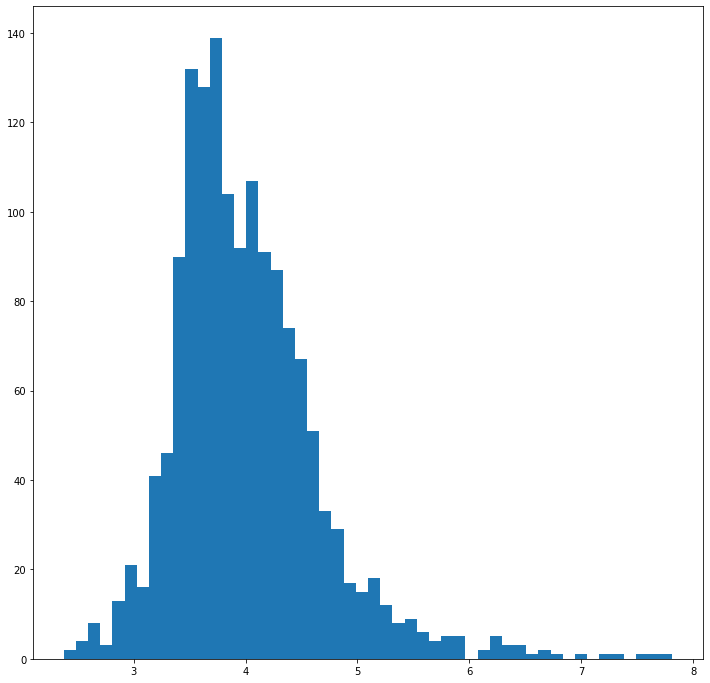

In [20]:
loss = []

for i in range(num_demo):
    l = np.sum((y_star[y_star>0] - Y_actual[i][y_star>0])**2 / (y_star[y_star>0])**2)
    loss.append(l)

print(min(loss))
print(np.mean(loss))
print(max(loss))

ind = np.argpartition(loss, -1000)[-1000:]
print(len(ind))

plt.hist(loss, bins=50)
len(loss)

0.3131432463163926
0.3565495613263015
0.3960248113126453


500

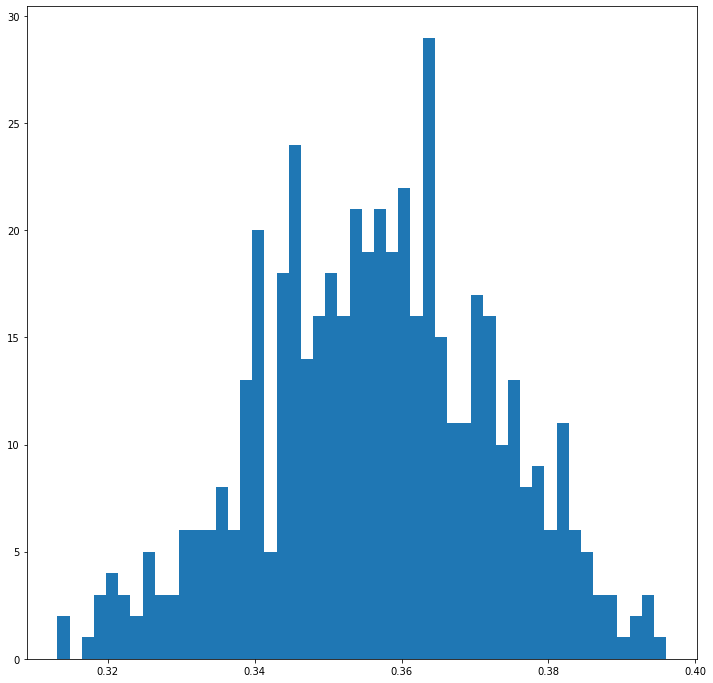

In [21]:
new_Q = np.delete(Q,ind,axis=0)
new_X = np.delete(X,ind,axis=0)
new_Y_actual = new_X@new_Q

new_norms = []
new_demo_count = new_Q.shape[0]
for i in range(new_demo_count):
    new_norms.append(LA.norm(y_star-new_Y_actual[i], 2))

new_norms = np.array(new_norms) / LA.norm(y_star, 2) #Normalization
print(min(new_norms))
print(np.mean(new_norms))
print(max(new_norms))

# plt.scatter(new_norms,np.linspace(0,1,len(new_norms)) )
plt.hist(new_norms,bins=50)
len(new_norms)

### NORM evaluation

0.31312524152542726
0.35771979137126564
0.40730260339022795
1000


1500

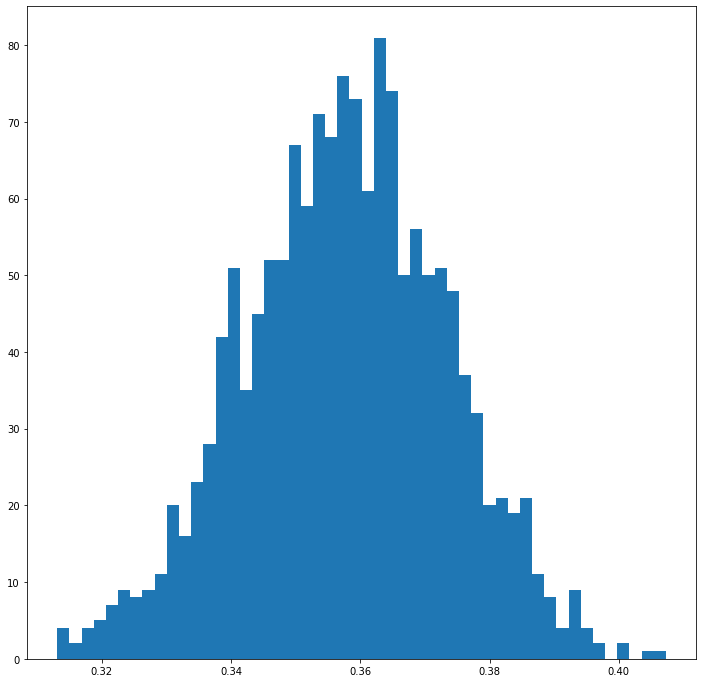

In [22]:
norms = []

for i in range(num_demo):
    norms.append(LA.norm(y_star-Y_actual[i], 2))
norms = np.array(norms)/LA.norm(y_star,2)
print(min(norms))
print(np.mean(norms))
print(max(norms))

ind = np.argpartition(norms, -1000)[-1000:]
print(len(ind))

plt.hist(norms, bins=50)
len(norms)

In [23]:
new_Q = np.delete(Q,ind,axis=0)
new_X = np.delete(X,ind,axis=0)

0.31312524152542726
0.34052137496271323
0.35104862704874934


500

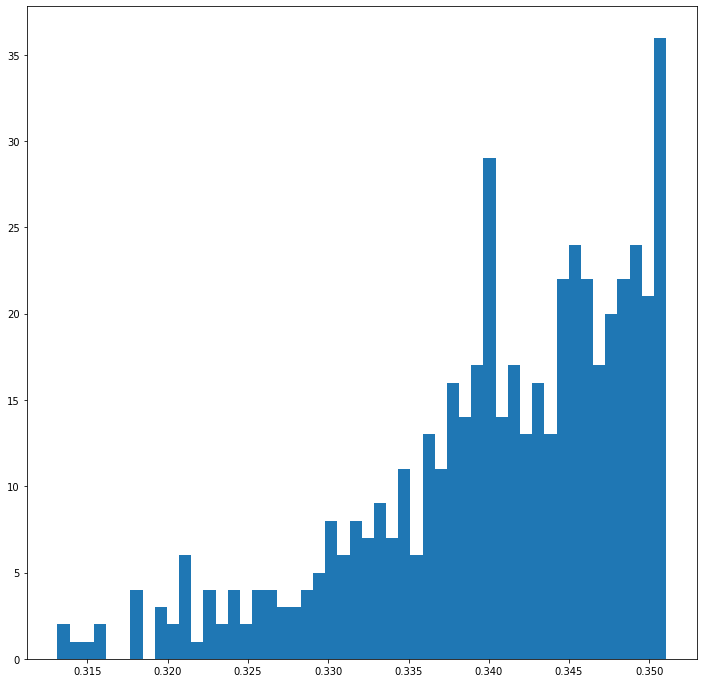

In [24]:
new_Y_actual = new_X@new_Q

new_norms = []
new_demo_count = new_Q.shape[0]
for i in range(new_demo_count):
    new_norms.append(LA.norm(y_star-new_Y_actual[i], 2))

new_norms = np.array(new_norms) / LA.norm(y_star, 2) #Normalization
print(min(new_norms))
print(np.mean(new_norms))
print(max(new_norms))

# plt.scatter(new_norms,np.linspace(0,1,len(new_norms)) )
plt.hist(new_norms,bins=50)
len(new_norms)

In [25]:
D = {'X': new_X, 'Q':new_Q, 'Y': new_Y_actual}
D.keys()

dict_keys(['X', 'Q', 'Y'])

In [26]:
np.mean(new_Y_actual, axis =0)

array([[ 161.3957382 ,  804.5648543 ,   81.10604001,   30.6025506 ,
         311.35065771, 2616.58547216,  673.81896212,   22.382     ,
         166.25800001],
       [ 110.5157906 , 1456.02583773,  109.65435719,   30.32133685,
         356.68493115, 2888.5223602 ,  771.07416847,   26.04      ,
         191.044     ],
       [  20.13672221,  603.34186761,   21.89122898,   11.66495892,
         106.90126027,  826.44298179,  231.0169144 ,    7.796     ,
          57.69      ]])

In [27]:
np.median(new_Y_actual, axis =0)

array([[ 161.99585927,  805.86318508,   79.32363077,   30.33979272,
         310.09445144, 2619.92843823,  686.08194512,   22.        ,
         166.        ],
       [ 108.89777622, 1454.40432713,  107.21712526,   30.59745802,
         358.39456505, 2887.52384839,  764.7967589 ,   26.        ,
         191.5       ],
       [  20.17259084,  614.8492452 ,   19.88267994,   11.51223661,
         108.05963713,  836.78795351,  233.87648114,    8.        ,
          56.        ]])

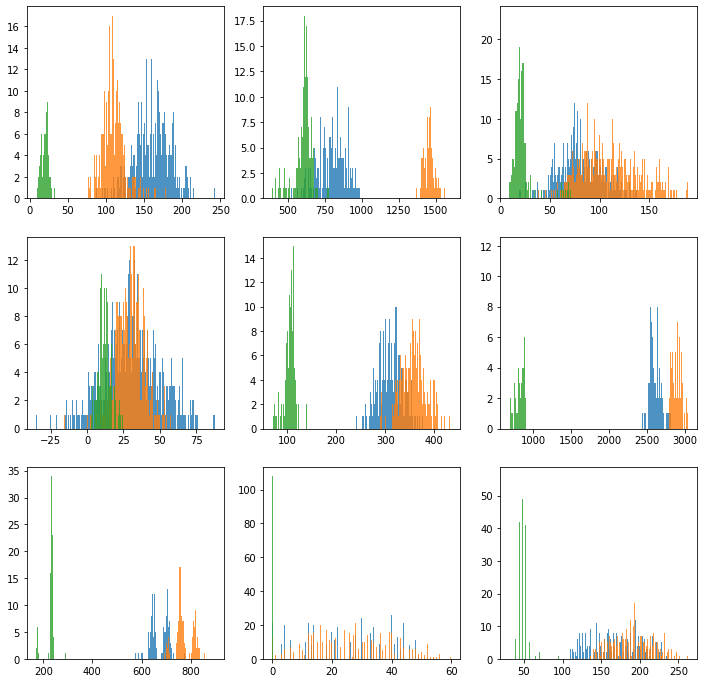

In [28]:
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.hist(new_Y_actual[:,0,i], bins=200, density=False,histtype='barstacked', alpha=0.8)
    ax.hist(new_Y_actual[:,1,i], bins=200, density=False,histtype='barstacked', alpha=0.8)
    ax.hist(new_Y_actual[:,2,i], bins=200, density=False,histtype='barstacked', alpha=0.8)


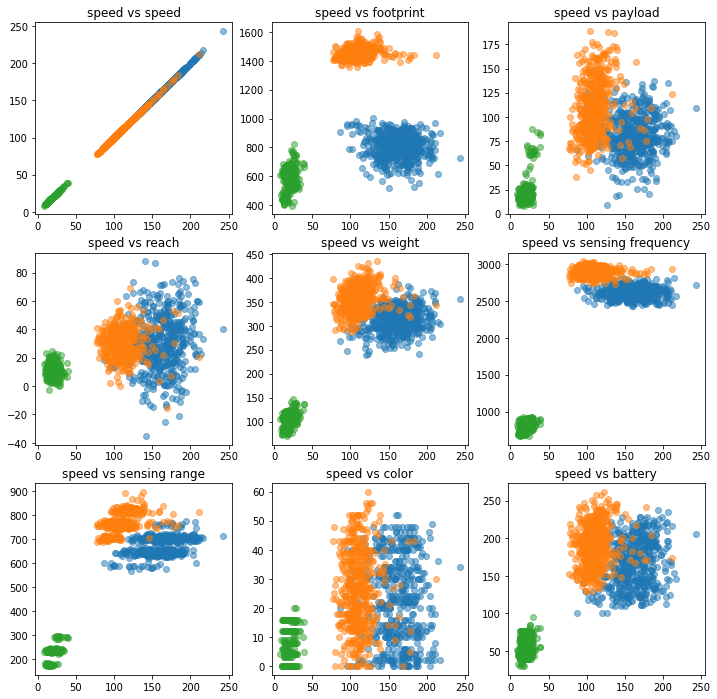

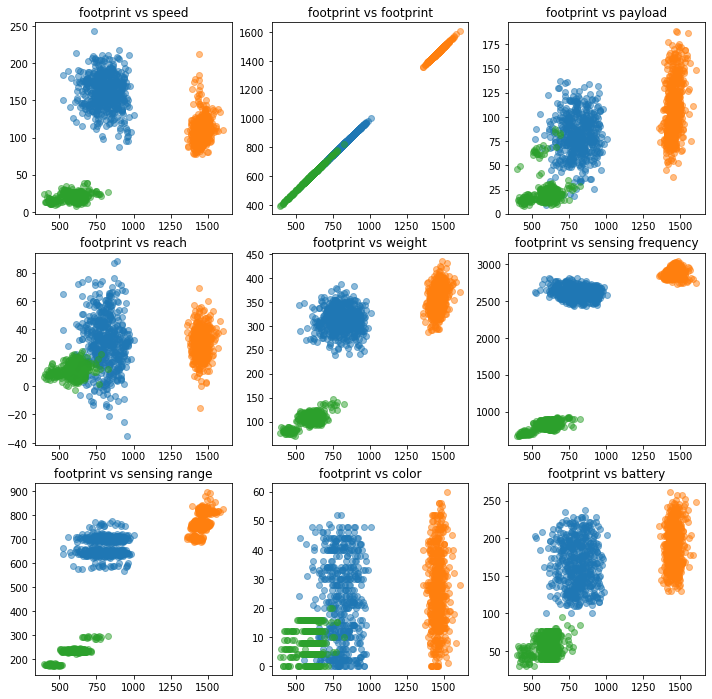

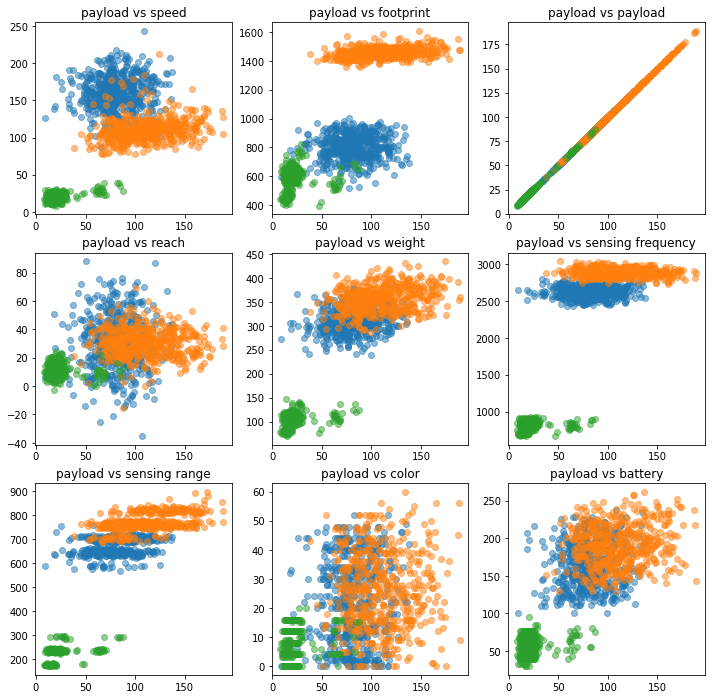

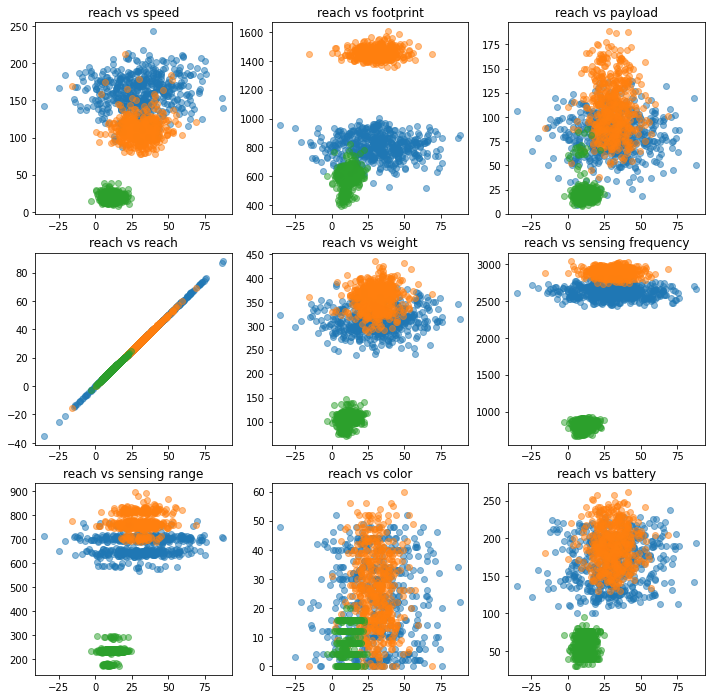

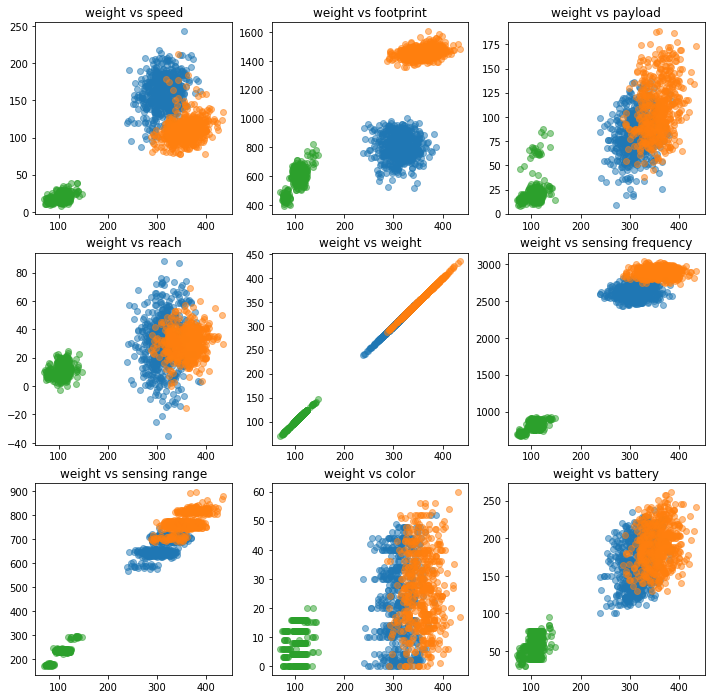

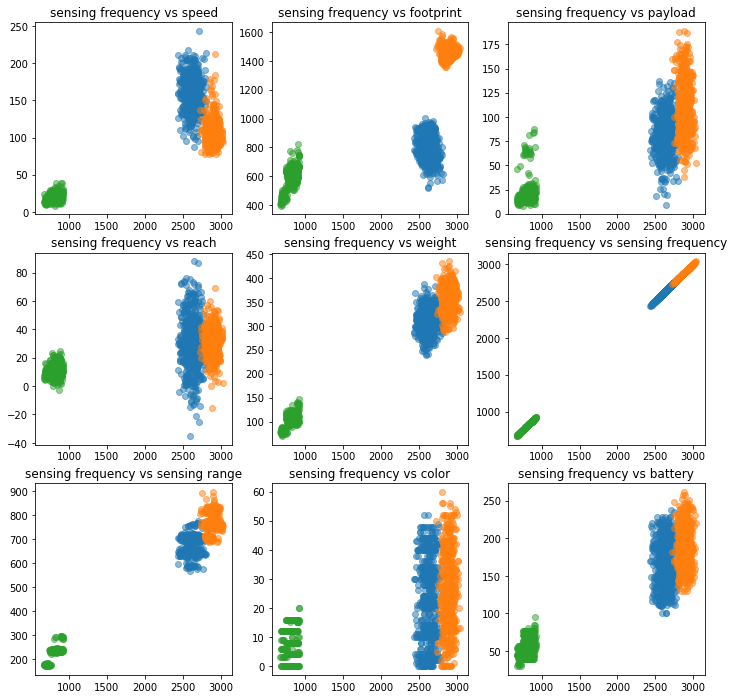

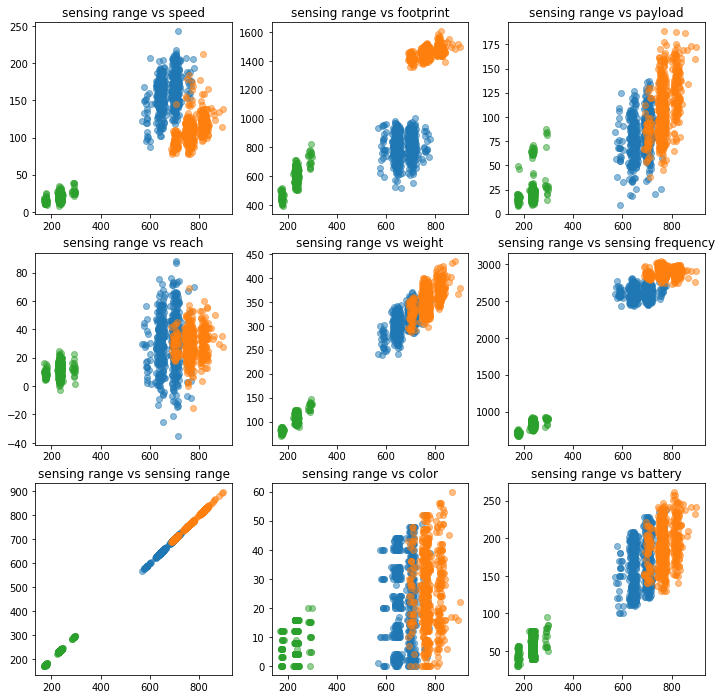

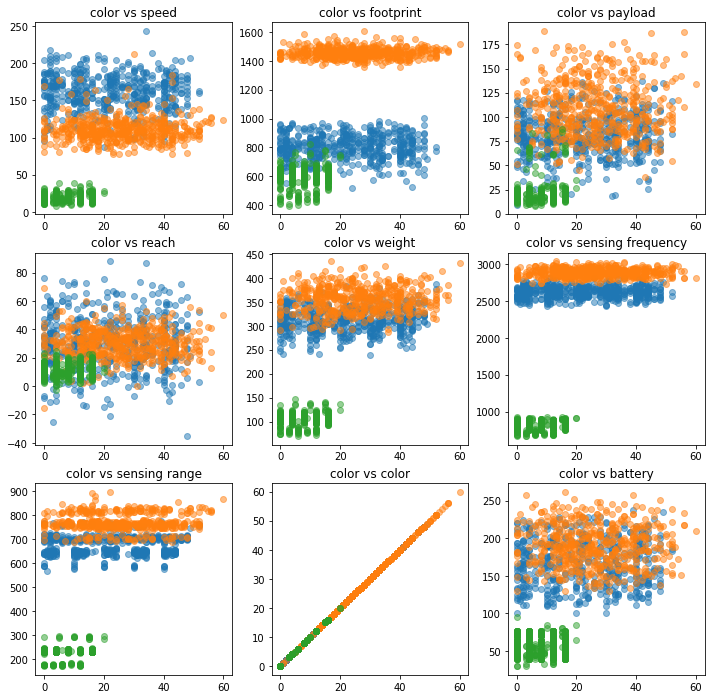

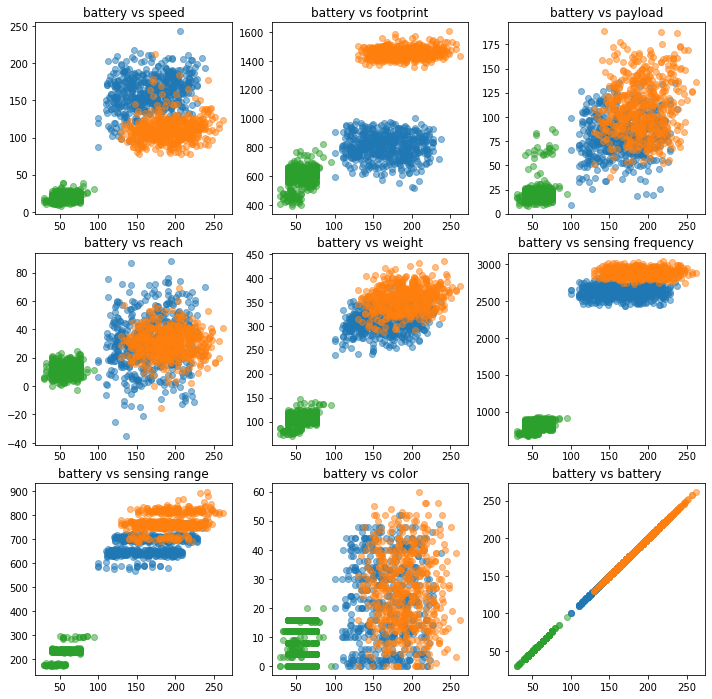

In [29]:
plt.rcParams["figure.figsize"] = (12,12)

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(new_Y_actual[:,0,t], new_Y_actual[:,0,i],alpha=0.5)
        ax.scatter(new_Y_actual[:,1,t], new_Y_actual[:,1,i],alpha=0.5)
        ax.scatter(new_Y_actual[:,2,t], new_Y_actual[:,2,i],alpha=0.5)

        ax.set_title(traits[t] + " vs "+ traits[i] )

In [30]:
Var_Y = np.var(new_Y_actual,axis=0)
Var_Y

array([[ 553.90012829, 7568.29070755,  472.56786655,  374.58738082,
         666.00704951, 5968.22547665, 1503.11748295,  213.82807592,
         996.80743568],
       [ 260.73427066, 1283.57025379,  832.77149739,   95.48419381,
         686.93054271, 3227.53281299, 1318.75297601,  177.6824    ,
         762.29806387],
       [  21.27224744, 3820.53875145,  122.94301557,   17.17156092,
         134.57368217, 3043.90451221,  418.21140902,   33.078384  ,
         147.50990004]])

In [31]:
Var_Q = np.var(new_Q,axis=0)
Var_Q

array([[  0.96204283,  25.56425951,   4.24069607,   1.00447405,
          3.05622655, 313.67347556,   0.84395981,   2.043856  ,
          8.168     ],
       [  0.884553  ,  71.29941354,   0.96783625,   0.99469462,
          2.97708542, 190.30330851,   0.87177177,   2.138064  ,
          8.032044  ],
       [  1.00640946, 101.96779932,   1.01064305,   1.07956815,
          2.8629371 , 276.45508023,   0.93406415,   2.008556  ,
          7.4731    ],
       [  4.08953999, 103.47061195,   4.06705285,   3.92586583,
          3.12942648, 205.50396599,   0.82048317,   2.0411    ,
          8.532704  ]])

In [32]:
print(new_Q[0],new_Q[1])

[[ 11.79045504  93.64651713   9.36257268  -0.51725414  28.20187504
  227.69201836  58.52963025   3.          19.        ]
 [  3.85636654 138.21071712   4.0161791    3.60227783  27.33716911
  214.91026351  58.08092192   3.          16.        ]
 [  7.08025417 121.22235454  15.39143346   2.05524784  29.01283311
  240.66485803  58.61776891   1.          10.        ]
 [ 11.0023847   50.24504609   9.46292724   0.87326844  27.88274266
  225.94306377  58.37373333   1.          18.        ]] [[ 10.1144598   87.97506226   9.36039791   2.30158855  28.27311776
  239.47086135  60.48937175   3.          11.        ]
 [  5.55416777 157.05938838   5.83397504   4.19113148  28.00692108
  219.48518589  58.62852139   3.          19.        ]
 [  7.46374167 119.91525859  15.04730251   1.05099303  29.76162127
  218.60907682  60.27070462   1.          17.        ]
 [ 12.2964129   64.20808073   6.21577488   3.5208704   27.29445582
  251.80698854  58.7951986    0.          10.        ]]


In [33]:
pca = PCA()
pca.fit(new_Y_actual[:,1,:])
# print(pca.get_covariance().shape)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

print(pca.n_samples_)
print(pca.n_features_)
print(pca.n_components_)
print(pca.singular_values_)

[3325.05622278 2549.37902853  762.57811355  681.02987498  560.91579588
  327.62287268  185.60324318  177.93368951   92.9643365 ]
[0.38381903 0.2942808  0.08802618 0.07861288 0.06474783 0.03781828
 0.02142462 0.0205393  0.01073109]
500
9
9
[1288.10056097 1127.89189874  616.86828307  582.95274904  529.05291054
  404.33131645  304.32879973  297.97468192  215.38153105]


## IMPLEMENTATION

In [34]:
Q_j = get_random_q()
y_hat = np.mean(new_Y_actual, axis =0)

In [35]:
X_sol = cp.Variable((num_tasks, num_species), integer=True)

# minimize trait mismatch
mismatch_mat = y_hat - cp.matmul(X_sol, Q_j)  # trait mismatch matrix
obj = cp.Minimize(cp.pnorm(mismatch_mat, 2))

# ensure each agent is only assigned to one task
constraints = [cp.matmul(X_sol.T, np.ones([num_tasks, 1])) <= np.array([n_agents_target]).T, X_sol >= 0]

# solve for X_target
opt_prob = cp.Problem(obj, constraints)
opt_prob.solve(solver=cp.CPLEX)
X_target = X_sol.value
print(X_target)

[[ 2.  0.  0. 10.]
 [ 6.  3.  4.  0.]
 [-0.  4.  0. -0.]]


In [36]:
print(LA.norm(y_star-X_target@Q_j,2)/LA.norm(y_star,2))
print(LA.norm(y_star-y_hat,2)/LA.norm(y_star,2))
print(LA.norm(y_hat-X_target@Q_j,2)/LA.norm(y_star,2))

0.34890069628495857
0.3391982016625695
0.01713212631643611


In [37]:
print(LA.norm(y_star-X_target@Q_j,2)/LA.norm(y_star,2))
print(LA.norm(y_star-y_hat,2)/LA.norm(y_star,2))
print(LA.norm(y_hat-X_target@Q_j,2)/LA.norm(y_star,2))

0.34890069628495857
0.3391982016625695
0.01713212631643611
